In [1]:
# -*- coding: utf-8 -*-
"""train_LSTM_v2_single_company_embedding_monthly.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1_i-FJwu3QwJ4bAk6zMrfthIA56NTooQH

# LSTM Model Training for Stock Price Forecasting (Monthly Data)

This notebook trains an LSTM model using PyTorch to forecast monthly returns for all stocks in the TQBR dataset.

## Architecture
- **Modular design**: Separate classes for Dataset, Model, and Trainer for easy extension
- **Target**: Monthly Return (percentage change from first day open to last day close)
- **Training & Validation**: Proper train/val split with metrics tracking
"""

'train_LSTM_v2_single_company_embedding_monthly.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1_i-FJwu3QwJ4bAk6zMrfthIA56NTooQH\n\n# LSTM Model Training for Stock Price Forecasting (Monthly Data)\n\nThis notebook trains an LSTM model using PyTorch to forecast monthly returns for all stocks in the TQBR dataset.\n\n## Architecture\n- **Modular design**: Separate classes for Dataset, Model, and Trainer for easy extension\n- **Target**: Monthly Return (percentage change from first day open to last day close)\n- **Training & Validation**: Proper train/val split with metrics tracking\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/DeepGap')

In [4]:
# Imports
import os
import glob
import warnings
from pathlib import Path
from typing import List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [5]:
# !pip install sentence-transformers
!pip install triton

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np

def generate_embeddings(text_df: pd.DataFrame, model_name: str = 'all-MiniLM-L6-v2') -> pd.DataFrame:
    """
    Generate embeddings for text data using a pre-trained sentence transformer model.

    Args:
        text_df: DataFrame with Ticker, Date and Text columns
        model_name: Name of the pre-trained model to use (default: all-MiniLM-L6-v2 ~80MB)

    Returns:
        DataFrame with Ticker, Date and Embedding columns
    """
    # Load the pre-trained model
    model = SentenceTransformer(model_name)
    print(f"Loaded model: {model_name}")

    # Generate embeddings
    print("Generating embeddings...")
    embeddings = model.encode(text_df['combined_text'].tolist(), show_progress_bar=True)

    # Add embeddings to dataframe
    text_df['Embedding'] = list(embeddings)

    return text_df

## Configuration

In [7]:
# Configuration
class Config:
    # Data paths
    DATA_DIR = "data/tqbr"

    # Model hyperparameters
    SEQUENCE_LENGTH = 12  # Number of months to look back (1 year)
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2
    BIDIRECTIONAL = False

    # Training hyperparameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    EARLY_STOPPING_PATIENCE = 10
    VALIDATION_SPLIT = 0.2

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model save path
    MODEL_SAVE_DIR = "models"
    MODEL_NAME = "lstm_monthly_return_model.pth"

config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cuda


## Data Loading and Preprocessing

In [8]:
def load_all_stock_data_monthly(data_dir: str) -> pd.DataFrame:
    """
    Load all CSV files from the data directory and combine them into monthly data.
    Returns a DataFrame with columns: ticker, YearMonth, Open, Close, Monthly_Return
    """
    all_data = []
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        ticker = Path(file_path).stem
        try:
            df = pd.read_csv(file_path)
            if 'Date' in df.columns and 'Open' in df.columns and 'Close' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')

                # Extract year and month for grouping
                df['YearMonth'] = df['Date'].dt.to_period('M')

                # Group by year-month
                monthly_groups = df.groupby('YearMonth')

                # For each month, get the first day's open and last day's close
                monthly_data = []
                for name, group in monthly_groups:
                    if len(group) < 2:  # Skip months with insufficient data
                        continue

                    first_day = group.iloc[0]
                    last_day = group.iloc[-1]

                    # Calculate monthly return: (close_last_day - open_first_day) / open_first_day * 100
                    monthly_return = (last_day['Close'] - first_day['Open']) / first_day['Open'] * 100

                    monthly_data.append({
                        'YearMonth': name,
                        'Open': first_day['Open'],
                        'Close': last_day['Close'],
                        'Monthly_Return': monthly_return,
                        'Ticker': ticker
                    })

                if monthly_data:
                    monthly_df = pd.DataFrame(monthly_data)
                    all_data.append(monthly_df)
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No data loaded!")

    combined_df = pd.concat(all_data, ignore_index=True)

    # Convert YearMonth to datetime for easier handling
    combined_df['Date'] = combined_df['YearMonth'].dt.to_timestamp()

    print(f"Total monthly records: {len(combined_df)}")
    print(f"Unique tickers: {combined_df['Ticker'].nunique()}")
    print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

    return combined_df

# Load monthly data
df_all = load_all_stock_data_monthly(config.DATA_DIR)
df_all.head()

Found 258 CSV files
Total monthly records: 28705
Unique tickers: 256
Date range: 2013-03-01 00:00:00 to 2025-10-01 00:00:00


,YearMonth,Open,Close,Monthly_Return,Ticker,Date
0,2013-09,33.000,36.000,9.090909,ALRS,2013-09-01
1,2013-10,35.559,36.219,1.856070,ALRS,2013-10-01
2,2013-11,36.511,34.914,-4.374024,ALRS,2013-11-01
3,2013-12,34.919,35.670,2.150692,ALRS,2013-12-01
4,2014-01,35.399,36.500,3.110257,ALRS,2014-01-01


In [9]:
df_all.sample(20)

# Clip extreme returns
df_all['Monthly_Return'] = np.clip(df_all.Monthly_Return.to_numpy(), -50.0, 50.0)

In [10]:
# Load sentiment data
def load_sentiment_data(sentiment_dir: str) -> pd.DataFrame:
    """
    Load all text CSV files and extract relevant information.
    Returns a DataFrame with Ticker, Date and Text columns
    """
    all_text = []
    text_files = glob.glob(os.path.join(sentiment_dir, "*_sentiment.csv"))

    print(f"Found {len(text_files)} text files")

    for file_path in text_files:
        try:
            # Extract ticker from filename
            ticker = os.path.basename(file_path).split('_sentiment.csv')[0]

            df_text = pd.read_csv(file_path)

            # Parse published date
            df_text['Date'] = pd.to_datetime(df_text['published'], errors='coerce', utc=True)
            df_text = df_text.dropna(subset=['Date'])

            # Extract year and month for grouping
            df_text['YearMonth'] = df_text['Date'].dt.to_period('M')

            # Add ticker column
            df_text['Ticker'] = ticker

            # Keep only necessary columns
            df_text = df_text[['Ticker', 'YearMonth', 'combined_text']].copy()

            all_text.append(df_text)
        except Exception as e:
            print(f"Error loading text file {file_path}: {e}")
            continue

    if not all_text:
        raise ValueError("No text data loaded!")

    combined_text = pd.concat(all_text, ignore_index=True)
    print(f"Total text events: {len(combined_text)}")
    print(f"Date range: {combined_text['YearMonth'].min()} to {combined_text['YearMonth'].max()}")
    print(f"Unique tickers in text data: {combined_text['Ticker'].nunique()}")

    return combined_text

# Load sentiment data
SENTIMENT_DIR = "data/sentiment"
sentiment_df = load_sentiment_data(SENTIMENT_DIR)
sentiment_df.head()

Found 30 text files
Total text events: 6441
Date range: 2015-01 to 2025-12
Unique tickers in text data: 30


,Ticker,YearMonth,combined_text
0,ROSN,2015-02,Леонтьев назвал «пшиком» ажиотаж вокруг зарпла...
1,ROSN,2015-04,Худайнатов оказался единственным владельцем Не...
2,ROSN,2015-05,«Роснефть» раскрыла ежемесячный оклад Игоря Се...
3,ROSN,2015-10,Торговля аксессуарами – самый прибыльный бизне...
4,ROSN,2016-05,Госкомпании экономят на дивидендах – обиженные...


In [11]:
# Generate embeddings for text data
sentiment_df = generate_embeddings(sentiment_df, model_name='all-MiniLM-L6-v2')
sentiment_df

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: all-MiniLM-L6-v2
Generating embeddings...


Batches:   0%|          | 0/202 [00:00<?, ?it/s]

,Ticker,YearMonth,combined_text,Embedding
0,ROSN,2015-02,Леонтьев назвал «пшиком» ажиотаж вокруг зарпла...,"[-0.016116502, -0.027094752, -0.014872677, 0.0..."
1,ROSN,2015-04,Худайнатов оказался единственным владельцем Не...,"[-0.021098413, -0.012143268, -0.042243935, -0...."
2,ROSN,2015-05,«Роснефть» раскрыла ежемесячный оклад Игоря Се...,"[-0.01664275, 0.01523391, -0.03421327, 0.01497..."
3,ROSN,2015-10,Торговля аксессуарами – самый прибыльный бизне...,"[0.0017044294, -0.09365192, -0.018351505, 0.02..."
4,ROSN,2016-05,Госкомпании экономят на дивидендах – обиженные...,"[0.026399646, 0.074507125, -0.017930718, 0.034..."
...,...,...,...,...
6436,HYDR,2025-12,Какие акции интересны под снижение ставки ЦБ и...,"[0.03639902, 0.047348235, -0.06844337, 0.05865..."
6437,HYDR,2025-12,Акции сектора электроэнергетики вновь в лидера...,"[0.05504837, 0.052995786, -0.09180143, -0.0183..."
6438,HYDR,2025-12,На чем растут электроэнергетики - Финам.Ру. На...,"[0.079165265, 0.023673268, -0.03485121, 0.0144..."
6439,HYDR,2024-07,Встреча с главой компании «РусГидро» Виктором ...,"[-0.01765502, 0.021336209, -0.017534807, 0.014..."


In [12]:
# Aggregate embeddings by month for each ticker
def aggregate_embeddings_by_month(text_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate embeddings by month for each ticker.
    Returns a DataFrame with Ticker, YearMonth and averaged Embedding columns
    """
    # Group by ticker and year-month
    grouped = text_df.groupby(['Ticker', 'YearMonth'])

    # Calculate average embedding for each group
    monthly_embeddings = []
    for (ticker, year_month), group in grouped:
        embeddings = np.array(group['Embedding'].tolist())
        avg_embedding = np.mean(embeddings, axis=0)

        monthly_embeddings.append({
            'Ticker': ticker,
            'YearMonth': year_month,
            'Date': year_month.to_timestamp(),
            'Monthly_Embedding': avg_embedding
        })

    result_df = pd.DataFrame(monthly_embeddings)
    return result_df

# Aggregate embeddings by month
monthly_embeddings_df = aggregate_embeddings_by_month(sentiment_df)
monthly_embeddings_df.head()

,Ticker,YearMonth,Date,Monthly_Embedding
0,AFKS,2015-05,2015-05-01,"[-0.0033273478, -0.011605102, -0.04280808, 0.0..."
1,AFKS,2016-06,2016-06-01,"[0.052046947, -0.045141388, -0.09005164, 0.045..."
2,AFKS,2016-07,2016-07-01,"[-0.0528816, -0.03138061, -0.013437746, -0.018..."
3,AFKS,2017-05,2017-05-01,"[0.073486246, 0.057532452, -0.057314467, 0.044..."
4,AFKS,2017-06,2017-06-01,"[-0.045220874, -0.036090497, -0.07161687, -0.0..."


In [13]:
## Merge Monthly Embeddings with Price Data

# Merge monthly embeddings with price data
df_combined = df_all.merge(monthly_embeddings_df, on=['Ticker', 'Date'], how='inner')

# Sort by Ticker and Date
df_combined = df_combined.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Combined dataset shape: {df_combined.shape}")
print(f"\nColumns: {df_combined.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_combined.head(10))

Combined dataset shape: (1475, 8)

Columns: ['YearMonth_x', 'Open', 'Close', 'Monthly_Return', 'Ticker', 'Date', 'YearMonth_y', 'Monthly_Embedding']

First few rows:
  YearMonth_x    Open   Close  Monthly_Return Ticker       Date YearMonth_y  \
0     2015-05  15.990  16.900        5.691057   AFKS 2015-05-01     2015-05   
1     2016-06  20.755  20.450       -1.469525   AFKS 2016-06-01     2016-06   
2     2016-07  20.380  23.055       13.125613   AFKS 2016-07-01     2016-07   
3     2017-05  21.545  12.455      -42.190764   AFKS 2017-05-01     2017-05   
4     2017-06  12.465  12.130       -2.687525   AFKS 2017-06-01     2017-06   
5     2017-07  12.240  12.000       -1.960784   AFKS 2017-07-01     2017-07   
6     2017-12  10.900  12.090       10.917431   AFKS 2017-12-01     2017-12   
7     2018-03  12.080  11.850       -1.903974   AFKS 2018-03-01     2018-03   
8     2018-04  11.850  11.230       -5.232068   AFKS 2018-04-01     2018-04   
9     2018-11   7.820   8.569        9.57800

In [14]:
def prepare_monthly_sequences_with_embeddings(df: pd.DataFrame, sequence_length: int, embedding_dim: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training with monthly data and embeddings.

    Args:
        df: DataFrame with Date, Ticker, Monthly_Return, and Monthly_Embedding columns
        sequence_length: Number of months to use as input
        embedding_dim: Dimension of the embedding vectors

    Returns:
        X: Array of shape (n_sequences, sequence_length, 1 + embedding_dim)
        y: Array of shape (n_sequences,) - next month's Monthly_Return
    """
    sequences_X = []
    sequences_y = []

    # Group by ticker to create sequences per stock
    for ticker, group in df.groupby('Ticker'):
        group = group.sort_values('Date').reset_index(drop=True)

        # Extract features
        monthly_returns = group['Monthly_Return'].values.reshape(-1, 1)
        embeddings = np.array(group['Monthly_Embedding'].tolist())

        # Combine features
        features = np.concatenate([monthly_returns, embeddings], axis=1)

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq_X = features[i:i+sequence_length]
            seq_y = features[i+sequence_length, 0]  # Target is Monthly_Return (first feature)

            sequences_X.append(seq_X)
            sequences_y.append(seq_y)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y

# Prepare sequences with monthly data and embeddings
embedding_dim = len(df_combined['Monthly_Embedding'].iloc[0])
X, y = prepare_monthly_sequences_with_embeddings(df_combined, config.SEQUENCE_LENGTH, embedding_dim)
print(f"\nMonthly Return statistics:")
print(f"Mean: {y.mean():.4f}, Std: {y.std():.4f}")
print(f"Min: {y.min():.4f}, Max: {y.max():.4f}")
print(f"\nInput features: Monthly_Return and Monthly_Embedding")
print(f"Input shape: {X.shape} (samples, sequence_length, features)")

Created 1152 sequences
X shape: (1152, 12, 385), y shape: (1152,)

Monthly Return statistics:
Mean: 0.1643, Std: 10.4613
Min: -50.0000, Max: 50.0000

Input features: Monthly_Return and Monthly_Embedding
Input shape: (1152, 12, 385) (samples, sequence_length, features)


In [15]:
print(X.shape)
print(y.shape)

(1152, 12, 385)
(1152,)


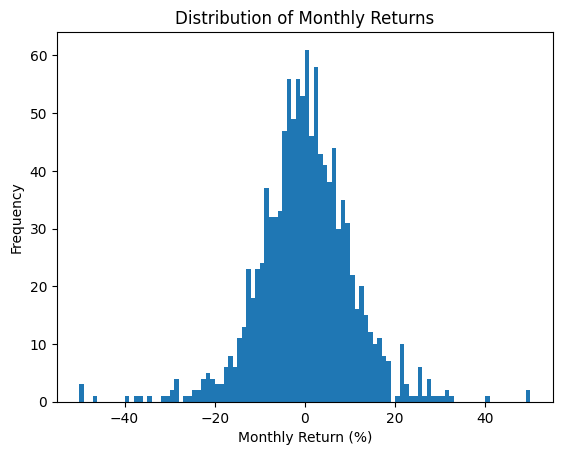

In [16]:
plt.hist(y, bins=100)
plt.title('Distribution of Monthly Returns')
plt.xlabel('Monthly Return (%)')
plt.ylabel('Frequency')
plt.show()

In [17]:
for q in (1.0, 0.999, 0.99, 0.98, 0.95, 0.001, 0.0):
  print(f"Quantile {q}: {np.quantile(y, q):.4f}")

Quantile 1.0: 50.0000
Quantile 0.999: 48.5239
Quantile 0.99: 27.2184
Quantile 0.98: 22.2194
Quantile 0.95: 16.5765
Quantile 0.001: -50.0000
Quantile 0.0: -50.0000


In [18]:
# Train/Validation split
def train_val_split(X: np.ndarray, y: np.ndarray, val_split: float = 0.2, shuffle: bool = True) -> Tuple:
    """Split data into train and validation sets using views to avoid copying."""
    n_samples = len(X)
    n_val = int(n_samples * val_split)

    if shuffle:
        # Create indices array and shuffle it
        indices = np.random.permutation(n_samples)

        # Create views using the shuffled indices
        X_train = X[indices[:-n_val]]
        X_val = X[indices[-n_val:]]
        y_train = y[indices[:-n_val]]
        y_val = y[indices[-n_val:]]
    else:
        # If not shuffling, we can directly create views
        X_train = X[:-n_val]
        X_val = X[-n_val:]
        y_train = y[:-n_val]
        y_val = y[-n_val:]

    print(f"Train: {len(X_train)} samples, Val: {len(X_val)} samples")
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_val_split(X, y, config.VALIDATION_SPLIT, shuffle=True)

print(f"\nAfter split:")
print(f"Train X - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Val X - Mean: {X_val.mean():.4f}, Std: {X_val.std():.4f}")

Train: 922 samples, Val: 230 samples

After split:
Train X - Mean: -0.0018, Std: 0.5393
Val X - Mean: -0.0015, Std: 0.5327


## Dataset and Model Classes (Modular Architecture)

In [19]:
class StockSequenceDataset(Dataset):
    """
    PyTorch Dataset for stock sequences.
    Modular design allows easy extension for additional features.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Args:
            X: Input sequences of shape (n_samples, sequence_length, n_features)
            y: Target values of shape (n_samples,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockSequenceDataset(X_train, y_train)
val_dataset = StockSequenceDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 15, Val batches: 4


In [20]:
class LSTMModel(nn.Module):
    """
    LSTM model for time series forecasting.
    Modular architecture allows easy extension (e.g., attention, multiple outputs).
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float = 0.2,
        bidirectional: bool = False
    ):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Calculate LSTM output size
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Fully connected layers
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output for regression

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            output: Tensor of shape (batch_size, 1)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last output (many-to-one architecture)
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out.squeeze(-1)  # (batch_size,)

In [22]:
# Initialize model with monthly data
n_features = X_train.shape[2]  # Should be 1 + embedding_dim: Monthly_Return and Monthly_Embedding
print(f"Number of input features: {n_features}")

model = LSTMModel(
    input_size=n_features,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized on {config.DEVICE}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model architecture summary
print("\nModel architecture:")
print(model)

Number of input features: 385
Model initialized on cuda
Total parameters: 412,417
Trainable parameters: 412,417

Model architecture:
LSTMModel(
  (lstm): LSTM(385, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


## Training and Validation

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Trainer:
    """
    Modular trainer class for LSTM model.
    Handles training loop, validation, early stopping, and metrics tracking.
    Now includes checkpointing functionality.
    """
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        device: torch.device,
        model_name: str = "lstm_model",
        early_stopping_patience: int = 10
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name
        self.early_stopping_patience = early_stopping_patience

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None

        # Create checkpoint directory if it doesn't exist
        self.checkpoint_dir = "checkpoints"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Path to the model checkpoint
        self.checkpoint_path = os.path.join(self.checkpoint_dir, f"{self.model_name}_best.pt")

    def train_epoch(self) -> float:
        """Train for one epoch and return average loss."""
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        for batch_X, batch_y in self.train_loader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_X)
            loss = self.criterion(predictions, batch_y)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        return total_loss / n_batches

    def validate(self) -> float:
        """Validate and return average loss."""
        self.model.eval()
        total_loss = 0.0
        n_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)

                total_loss += loss.item()
                n_batches += 1

        return total_loss / n_batches

    def save_checkpoint(self, is_best: bool, epoch: int, val_loss: float):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

        # Save the latest checkpoint
        torch.save(checkpoint, os.path.join(self.checkpoint_dir, f"{self.model_name}_latest.pt"))

        # Save the best checkpoint if this is the best model
        if is_best:
            torch.save(checkpoint, self.checkpoint_path)
            print(f"New best model saved with validation loss: {val_loss:.6f}")

    def load_checkpoint(self):
        """Load model checkpoint if it exists."""
        if os.path.exists(self.checkpoint_path):
            print(f"Loading checkpoint from {self.checkpoint_path}")
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.val_losses = checkpoint.get('val_losses', [])
            self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
            print(f"Best validation loss so far: {self.best_val_loss:.6f}")
            return start_epoch
        else:
            print("No checkpoint found. Starting training from scratch.")
            return 0

    def train(self, num_epochs: int) -> dict:
        """Main training loop with early stopping and checkpointing."""
        # Try to load a checkpoint if it exists
        start_epoch = self.load_checkpoint()

        print("Starting training...")
        print(f"{'Epoch':<8} {'Train Loss':<15} {'Val Loss':<15} {'Status':<10}")
        print("-" * 50)

        for epoch in range(start_epoch, num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Early stopping check
            is_best = False
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                is_best = True
                status = "Improved"
            else:
                self.patience_counter += 1
                status = f"Patience {self.patience_counter}/{self.early_stopping_patience}"

            # Save checkpoint if this is the best model
            if is_best:
                self.save_checkpoint(is_best, epoch, val_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"{epoch+1:<8} {train_loss:<15.6f} {val_loss:<15.6f} {status:<10}")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"\nTraining completed. Best validation loss: {self.best_val_loss:.6f}")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

In [25]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.MSELoss()

# Create trainer with model name
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=config.DEVICE,
    model_name="lstm_monthly_returns_embeddings",
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

# Train model
history = trainer.train(config.NUM_EPOCHS)

No checkpoint found. Starting training from scratch.
Starting training...
Epoch    Train Loss      Val Loss        Status    
--------------------------------------------------
New best model saved with validation loss: 113.690994
1        105.460305      113.690994      Improved  
New best model saved with validation loss: 113.620249
New best model saved with validation loss: 112.607412
5        107.424638      112.607412      Improved  
10       102.512273      117.502317      Patience 5/10
15       99.992629       119.282347      Patience 10/10

Early stopping triggered at epoch 15

Training completed. Best validation loss: 112.607412


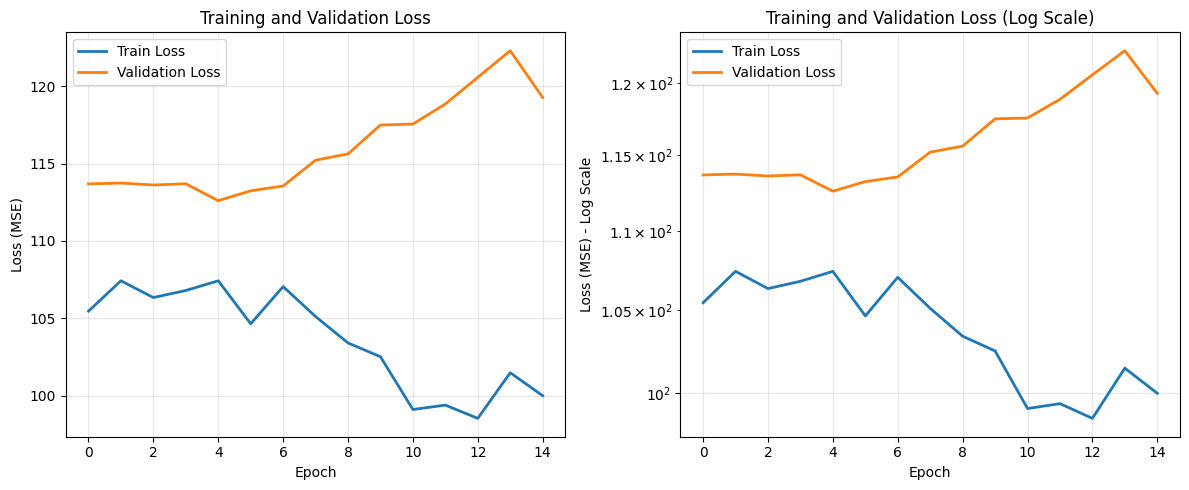

In [26]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE) - Log Scale')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Evaluation

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by filtering out zero values in y_true
    mask = y_true != 0
    if np.sum(mask) == 0:
        # If all values are zero, return 0 to avoid division by zero
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model: nn.Module, data_loader: DataLoader, device: torch.device) -> dict:
    """Evaluate model and return metrics."""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets, predictions)

    # Calculate directional accuracy (sign prediction)
    pred_sign = np.sign(predictions)
    target_sign = np.sign(targets)
    directional_accuracy = (pred_sign == target_sign).mean() * 100

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'directional_accuracy': directional_accuracy,
        'predictions': predictions,
        'targets': targets
    }

In [28]:
# Evaluate on train and validation sets
print("Evaluating model...")
train_metrics = evaluate_model(model, train_loader, config.DEVICE)
val_metrics = evaluate_model(model, val_loader, config.DEVICE)

print("\n" + "="*50)
print("TRAINING SET METRICS")
print("="*50)
print(f"MSE:  {train_metrics['mse']:.6f}")
print(f"RMSE: {train_metrics['rmse']:.6f}")
print(f"MAE:  {train_metrics['mae']:.6f}")
print(f"MAPE: {train_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {train_metrics['directional_accuracy']:.2f}%")

print("\n" + "="*50)
print("VALIDATION SET METRICS")
print("="*50)
print(f"MSE:  {val_metrics['mse']:.6f}")
print(f"RMSE: {val_metrics['rmse']:.6f}")
print(f"MAE:  {val_metrics['mae']:.6f}")
print(f"MAPE: {val_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {val_metrics['directional_accuracy']:.2f}%")

Evaluating model...

TRAINING SET METRICS
MSE:  94.755348
RMSE: 9.734236
MAE:  7.263121
MAPE: 196.66%
Directional Accuracy: 58.35%

VALIDATION SET METRICS
MSE:  122.196304
RMSE: 11.054244
MAE:  7.985200
MAPE: 187.20%
Directional Accuracy: 46.52%


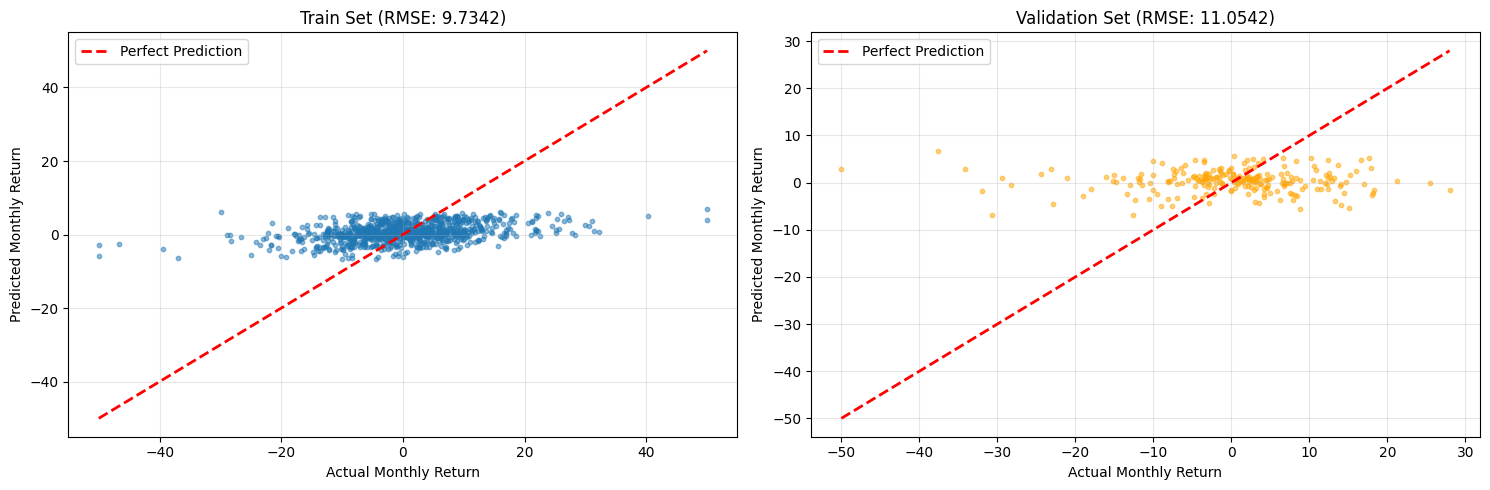

In [29]:
# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(train_metrics['targets'], train_metrics['predictions'], alpha=0.5, s=10)
axes[0].plot([train_metrics['targets'].min(), train_metrics['targets'].max()],
              [train_metrics['targets'].min(), train_metrics['targets'].max()],
              'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Monthly Return')
axes[0].set_ylabel('Predicted Monthly Return')
axes[0].set_title(f'Train Set (RMSE: {train_metrics["rmse"]:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(val_metrics['targets'], val_metrics['predictions'], alpha=0.5, s=10, color='orange')
axes[1].plot([val_metrics['targets'].min(), val_metrics['targets'].max()],
             [val_metrics['targets'].min(), val_metrics['targets'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Monthly Return')
axes[1].set_ylabel('Predicted Monthly Return')
axes[1].set_title(f'Validation Set (RMSE: {val_metrics["rmse"]:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

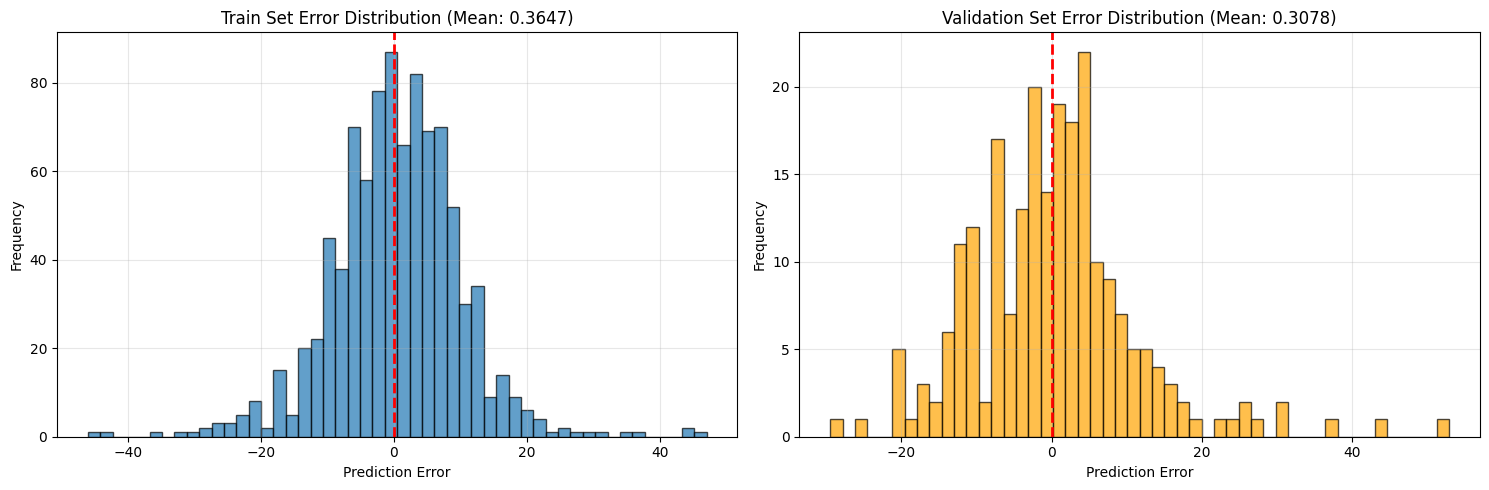

In [30]:
# Plot error distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_errors = train_metrics['predictions'] - train_metrics['targets']
val_errors = val_metrics['predictions'] - val_metrics['targets']

axes[0].hist(train_errors, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set Error Distribution (Mean: {train_errors.mean():.4f})')
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(val_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set Error Distribution (Mean: {val_errors.mean():.4f})')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Supervised Baseline Check

In [38]:
# Train basic sklearn models for baseline comparison
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [32]:
def prepare_data_for_sklearn(df: pd.DataFrame, sequence_length: int, embedding_dim: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare data for sklearn models by flattening sequences.

    Args:
        df: DataFrame with Date, Ticker, Monthly_Return, and Monthly_Embedding columns
        sequence_length: Number of months to use as input
        embedding_dim: Dimension of the embedding vectors

    Returns:
        X: Array of shape (n_sequences, sequence_length * (1 + embedding_dim))
        y: Array of shape (n_sequences,) - next month's Monthly_Return
    """
    sequences_X = []
    sequences_y = []

    # Group by ticker to create sequences per stock
    for ticker, group in df.groupby('Ticker'):
        group = group.sort_values('Date').reset_index(drop=True)

        # Extract features
        monthly_returns = group['Monthly_Return'].values.reshape(-1, 1)
        embeddings = np.array(group['Monthly_Embedding'].tolist())

        # Combine features
        features = np.concatenate([monthly_returns, embeddings], axis=1)

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq_X = features[i:i+sequence_length].flatten()  # Flatten the sequence
            seq_y = features[i+sequence_length, 0]  # Target is Monthly_Return (first feature)

            sequences_X.append(seq_X)
            sequences_y.append(seq_y)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences with length {sequence_length}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y

In [33]:
# Prepare data for different sequence lengths
embedding_dim = len(df_combined['Monthly_Embedding'].iloc[0])

# For 6 months sequence
X_6, y_6 = prepare_data_for_sklearn(df_combined, 6, embedding_dim)
X_train_6, X_val_6, y_train_6, y_val_6 = train_val_split(X_6, y_6, config.VALIDATION_SPLIT, shuffle=True)

# For 12 months sequence
X_12, y_12 = prepare_data_for_sklearn(df_combined, 12, embedding_dim)
X_train_12, X_val_12, y_train_12, y_val_12 = train_val_split(X_12, y_12, config.VALIDATION_SPLIT, shuffle=True)

Created 1310 sequences with length 6
X shape: (1310, 2310), y shape: (1310,)
Train: 1048 samples, Val: 262 samples
Created 1152 sequences with length 12
X shape: (1152, 4620), y shape: (1152,)
Train: 922 samples, Val: 230 samples


In [34]:
# # Standardize features
# scaler_6 = StandardScaler()
# X_train_6 = scaler_6.fit_transform(X_train_6)
# X_val_6 = scaler_6.transform(X_val_6)

# scaler_12 = StandardScaler()
# X_train_12 = scaler_12.fit_transform(X_train_12)
# X_val_12 = scaler_12.transform(X_val_12)

In [39]:
# Define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
}

In [49]:
svr_models = {
    'SVR_1e0': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'SVR_1esub1': SVR(kernel='rbf', C=0.1, gamma='scale'),
    'SVR_1esub2': SVR(kernel='rbf', C=0.01, gamma='scale'),
    'SVR_1esub3': SVR(kernel='rbf', C=0.001, gamma='scale'),
    'SVR_1esub4': SVR(kernel='rbf', C=1.e-4, gamma='scale'),
    'SVR_1esub5': SVR(kernel='rbf', C=1.e-5, gamma='scale'),
}

In [48]:
np.sum(y_val >= 0.0) / len(y_val)

np.float64(0.5478260869565217)

In [40]:
# Function to evaluate models
def evaluate_sklearn_model(model, X_train, y_train, X_val, y_val, model_name):
    """Train and evaluate a sklearn model."""
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_pred)

    val_mse = mean_squared_error(y_val, val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, val_pred)

    # Directional accuracy
    train_dir_acc = (np.sign(train_pred) == np.sign(y_train)).mean() * 100
    val_dir_acc = (np.sign(val_pred) == np.sign(y_val)).mean() * 100

    return {
        'model_name': model_name,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_dir_acc': train_dir_acc,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_dir_acc': val_dir_acc
    }

In [41]:
# Train and evaluate models for 6-month sequence
results_6 = []
for name, model in models.items():
    result = evaluate_sklearn_model(model, X_train_6, y_train_6, X_val_6, y_val_6, name)
    results_6.append(result)


Training Linear Regression...

Training Ridge Regression...

Training Lasso Regression...

Training ExtraTrees...

Training Gradient Boosting...

Training SVR...


In [42]:
# Train and evaluate models for 12-month sequence
results_12 = []
for name, model in models.items():
    result = evaluate_sklearn_model(model, X_train_12, y_train_12, X_val_12, y_val_12, name)
    results_12.append(result)


Training Linear Regression...

Training Ridge Regression...

Training Lasso Regression...

Training ExtraTrees...

Training Gradient Boosting...

Training SVR...


In [50]:
# Train and evaluate models for 12-month sequence
results_svr_12 = []
for name, model in svr_models.items():
    result = evaluate_sklearn_model(model, X_train_12, y_train_12, X_val_12, y_val_12, name)
    results_svr_12.append(result)


Training SVR_1e0...

Training SVR_1esub1...

Training SVR_1esub2...

Training SVR_1esub3...

Training SVR_1esub4...

Training SVR_1esub5...


In [51]:
# Create DataFrames for results
results_df_6 = pd.DataFrame(results_6)
results_df_12 = pd.DataFrame(results_12)
results_df_svr_12 = pd.DataFrame(results_svr_12)

# Display results
print("\n" + "="*60)
print("6-MONTH SEQUENCE RESULTS")
print("="*60)
print(results_df_6[['model_name', 'train_rmse', 'val_rmse', 'train_dir_acc', 'val_dir_acc']].sort_values('val_rmse'))

print("\n" + "="*60)
print("12-MONTH SEQUENCE RESULTS")
print("="*60)
print(results_df_12[['model_name', 'train_rmse', 'val_rmse', 'train_dir_acc', 'val_dir_acc']].sort_values('val_rmse'))

print("\n" + "="*60)
print("12-MONTH SEQUENCE RESULTS, SVR model")
print("="*60)
print(results_df_svr_12[['model_name', 'train_rmse', 'val_rmse', 'train_dir_acc', 'val_dir_acc']].sort_values('val_rmse'))

# Compare with LSTM model
print("\n" + "="*60)
print("COMPARISON WITH LSTM MODEL")
print("="*60)
print(f"LSTM Model (12 months):")
print(f"  Train RMSE: {train_metrics['rmse']:.6f}")
print(f"  Validation RMSE: {val_metrics['rmse']:.6f}")
print(f"  Train Directional Accuracy: {train_metrics['directional_accuracy']:.2f}%")
print(f"  Validation Directional Accuracy: {val_metrics['directional_accuracy']:.2f}%")


6-MONTH SEQUENCE RESULTS
          model_name  train_rmse   val_rmse  train_dir_acc  val_dir_acc
5                SVR   10.140558  10.175747      60.019084    56.106870
2   Lasso Regression   10.367046  10.302344      50.763359    47.328244
3         ExtraTrees    0.000000  10.338291     100.000000    52.290076
4  Gradient Boosting    5.560233  10.452110      85.209924    54.961832
1   Ridge Regression    7.521344  11.051774      74.236641    54.198473
0  Linear Regression    0.598862  20.009759      97.328244    51.526718

12-MONTH SEQUENCE RESULTS
          model_name  train_rmse   val_rmse  train_dir_acc  val_dir_acc
5                SVR   10.336068   9.062375      71.258134    58.260870
2   Lasso Regression   10.610058   9.470180      52.711497    47.826087
4  Gradient Boosting    4.563398   9.557812      90.889371    55.652174
3         ExtraTrees    0.000000   9.630133     100.000000    47.826087
1   Ridge Regression    5.688410  10.876910      82.971800    45.652174
0  Linear R

In [44]:
# Plot comparison of RMSE for different models
plt.figure(figsize=(12, 6))

# Combine results for plotting
combined_results = pd.concat([
    results_df_6.assign(sequence_length='6 months'),
    results_df_12.assign(sequence_length='12 months')
])

# Add LSTM results
lstm_results = pd.DataFrame({
    'model_name': ['LSTM'],
    'val_rmse': [val_metrics['rmse']],
    'val_dir_acc': [val_metrics['directional_accuracy']],
    'sequence_length': ['12 months']
})

combined_results = pd.concat([combined_results, lstm_results])


<Figure size 1200x600 with 0 Axes>

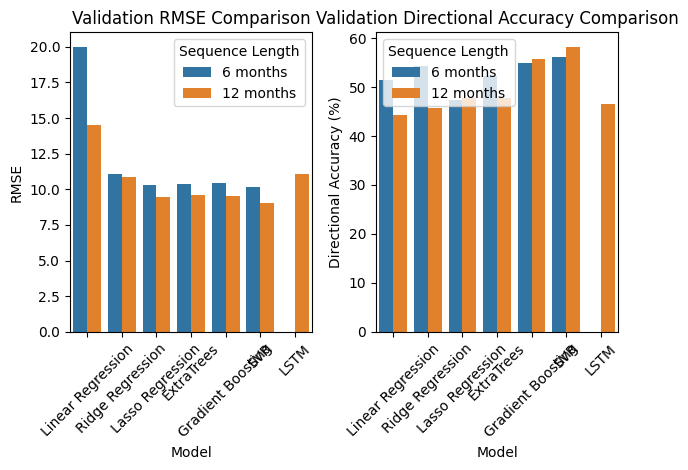

In [45]:
# Plot RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='val_rmse', hue='sequence_length', data=combined_results)
plt.title('Validation RMSE Comparison')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sequence Length')

# Plot Directional Accuracy
plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='val_dir_acc', hue='sequence_length', data=combined_results)
plt.title('Validation Directional Accuracy Comparison')
plt.ylabel('Directional Accuracy (%)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sequence Length')

plt.tight_layout()
plt.show()

In [52]:
# # Feature importance for tree-based models
# def plot_feature_importance(model, model_name, feature_names, sequence_length):
#     """Plot feature importance for tree-based models."""
#     if hasattr(model, 'feature_importances_'):
#         importances = model.feature_importances_
#         indices = np.argsort(importances)[::-1]

#         # Group features by month and type
#         monthly_returns_indices = [i for i in range(sequence_length)]
#         embedding_indices = [i for i in range(sequence_length, len(importances))]

#         plt.figure(figsize=(12, 6))

#         # Plot top 20 features
#         top_n = min(20, len(importances))
#         plt.title(f'Top {top_n} Feature Importances - {model_name}')
#         plt.bar(range(top_n), importances[indices[:top_n]], align='center')

#         # Create labels for top features
#         feature_labels = []
#         for i in indices[:top_n]:
#             if i in monthly_returns_indices:
#                 feature_labels.append(f"Monthly Return (Month {i+1})")
#             else:
#                 embedding_idx = i - sequence_length
#                 feature_labels.append(f"Embedding {embedding_idx}")

#         plt.xticks(range(top_n), feature_labels, rotation=90)
#         plt.tight_layout()
#         plt.show()

In [53]:
# # Plot feature importance for Random Forest and Gradient Boosting
# rf_6 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_6.fit(X_train_6, y_train_6)
# plot_feature_importance(rf_6, "Random Forest (6 months)", None, 6)

# rf_12 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_12.fit(X_train_12, y_train_12)
# plot_feature_importance(rf_12, "Random Forest (12 months)", None, 12)

# gb_6 = GradientBoostingRegressor(n_estimators=100, random_state=42)
# gb_6.fit(X_train_6, y_train_6)
# plot_feature_importance(gb_6, "Gradient Boosting (6 months)", None, 6)

# gb_12 = GradientBoostingRegressor(n_estimators=100, random_state=42)
# gb_12.fit(X_train_12, y_train_12)
# plot_feature_importance(gb_12, "Gradient Boosting (12 months)", None, 12)

## Mutual information for feature space reduction

In [54]:
# Apply Mutual Information analysis to select top embedding components
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

def select_top_embedding_components(X_train, y_train, embedding_dim, top_k=20):
    """
    Select top k embedding components based on mutual information with target.

    Args:
        X_train: Training data of shape (n_samples, sequence_length * (1 + embedding_dim))
        y_train: Target values
        embedding_dim: Dimension of the original embedding vectors
        top_k: Number of top components to select

    Returns:
        selected_indices: Indices of selected embedding components
        mi_scores: Mutual information scores for all components
    """
    # Separate features: monthly returns and embeddings
    n_features_per_month = 1 + embedding_dim
    sequence_length = X_train.shape[1] // n_features_per_month

    # Extract embedding features (skip monthly returns which are at positions 0, n_features_per_month, 2*n_features_per_month, etc.)
    embedding_indices = []
    for i in range(sequence_length):
        start_idx = i * n_features_per_month + 1  # Skip the monthly return at position 0
        end_idx = start_idx + embedding_dim
        embedding_indices.extend(range(start_idx, end_idx))

    X_embeddings = X_train[:, embedding_indices]

    # Calculate mutual information for each embedding component
    mi_scores = mutual_info_regression(X_embeddings, y_train, random_state=42)

    # Get indices of top k components
    selected_indices = np.argsort(mi_scores)[-top_k:]
    selected_indices = selected_indices[np.argsort(mi_scores[selected_indices])[::-1]]  # Sort by importance

    # Map back to original feature indices
    original_indices = [embedding_indices[i] for i in selected_indices]

    return original_indices, mi_scores, selected_indices

In [55]:
# Apply MI analysis for 12-month sequence
print("Performing Mutual Information analysis for 12-month sequence...")
selected_indices_12, mi_scores_12, selected_embedding_indices_12 = select_top_embedding_components(
    X_train_12, y_train_12, embedding_dim, top_k=20
)

print(f"\nTop 20 embedding components selected for 12-month sequence")
print(f"Selected embedding indices: {selected_embedding_indices_12}")
print(f"Corresponding feature indices: {selected_indices_12}")

Performing Mutual Information analysis for 12-month sequence...

Top 20 embedding components selected for 12-month sequence
Selected embedding indices: [1776 2678 3433 3291 1414 2486 3777   79 2973 3164 1252 2686 2192  266
 1204  628 4545 3064 1742 4452]
Corresponding feature indices: [1781, 2685, 3442, 3300, 1418, 2493, 3787, 80, 2981, 3173, 1256, 2693, 2198, 267, 1208, 630, 4557, 3072, 1747, 4464]


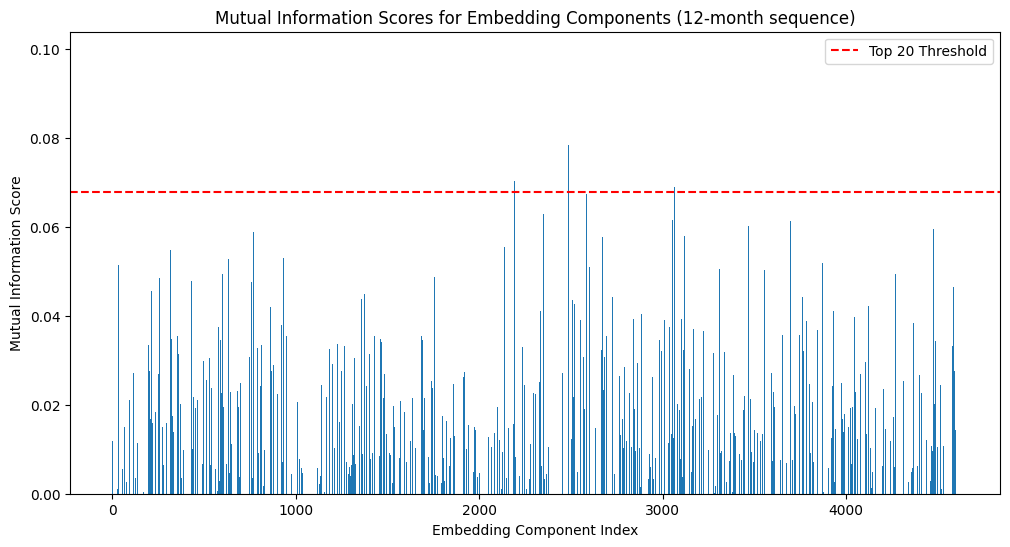

In [56]:
# Visualize MI scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores_12)), mi_scores_12)
plt.title('Mutual Information Scores for Embedding Components (12-month sequence)')
plt.xlabel('Embedding Component Index')
plt.ylabel('Mutual Information Score')
plt.axhline(y=np.sort(mi_scores_12)[-20], color='r', linestyle='--', label='Top 20 Threshold')
plt.legend()
plt.show()

In [57]:
# Create reduced datasets with selected components
def create_reduced_dataset(X, selected_indices, n_features_per_month):
    """
    Create a reduced dataset using only selected embedding components.

    Args:
        X: Original dataset
        selected_indices: Indices of selected embedding components
        n_features_per_month: Number of features per month (1 + embedding_dim)

    Returns:
        X_reduced: Reduced dataset
    """
    # Always include monthly returns (at positions 0, n_features_per_month, 2*n_features_per_month, etc.)
    sequence_length = X.shape[1] // n_features_per_month
    return_indices = []

    # Add monthly return indices
    for i in range(sequence_length):
        return_indices.append(i * n_features_per_month)

    # Add selected embedding indices
    return_indices.extend(selected_indices)

    # Sort indices to maintain order
    return_indices = sorted(return_indices)

    return X[:, return_indices]

In [58]:
# Create reduced datasets for 12-month sequence
n_features_per_month = 1 + embedding_dim
X_train_12_reduced = create_reduced_dataset(X_train_12, selected_indices_12, n_features_per_month)
X_val_12_reduced = create_reduced_dataset(X_val_12, selected_indices_12, n_features_per_month)

print(f"\nOriginal feature shape: {X_train_12.shape}")
print(f"Reduced feature shape: {X_train_12_reduced.shape}")
print(f"Reduction ratio: {X_train_12_reduced.shape[1] / X_train_12.shape[1]:.2%}")


Original feature shape: (922, 4620)
Reduced feature shape: (922, 32)
Reduction ratio: 0.69%


In [59]:
# # Standardize reduced features
# scaler_12_reduced = StandardScaler()
# X_train_12_reduced = scaler_12_reduced.fit_transform(X_train_12_reduced)
# X_val_12_reduced = scaler_12_reduced.transform(X_val_12_reduced)

In [60]:
# Retrain LSTM model with reduced features
print("\n" + "="*60)
print("RETRAINING LSTM MODEL WITH REDUCED FEATURES")
print("="*60)

# Prepare data for LSTM with reduced features
def prepare_sequences_with_reduced_embeddings(df: pd.DataFrame, sequence_length: int, selected_embedding_indices: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training with selected embedding components only.

    Args:
        df: DataFrame with Date, Ticker, Monthly_Return, and Monthly_Embedding columns
        sequence_length: Number of months to use as input
        selected_embedding_indices: Indices of selected embedding components

    Returns:
        X: Array of shape (n_sequences, sequence_length, 1 + len(selected_embedding_indices))
        y: Array of shape (n_sequences,) - next month's Monthly_Return
    """
    sequences_X = []
    sequences_y = []

    # Group by ticker to create sequences per stock
    for ticker, group in df.groupby('Ticker'):
        group = group.sort_values('Date').reset_index(drop=True)

        # Extract features
        monthly_returns = group['Monthly_Return'].values.reshape(-1, 1)
        embeddings = np.array(group['Monthly_Embedding'].tolist())

        # Select only the top embedding components
        selected_embeddings = embeddings[:, selected_embedding_indices]

        # Combine features
        features = np.concatenate([monthly_returns, selected_embeddings], axis=1)

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq_X = features[i:i+sequence_length]
            seq_y = features[i+sequence_length, 0]  # Target is Monthly_Return (first feature)

            sequences_X.append(seq_X)
            sequences_y.append(seq_y)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences with {len(selected_embedding_indices)} selected embedding components")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y

# Prepare sequences with selected embedding components
X_reduced, y_reduced = prepare_sequences_with_reduced_embeddings(
    df_combined, config.SEQUENCE_LENGTH, selected_embedding_indices_12
)

# Train/Validation split
X_train_reduced, X_val_reduced, y_train_reduced, y_val_reduced = train_val_split(
    X_reduced, y_reduced, config.VALIDATION_SPLIT, shuffle=True
)

# Create datasets and loaders
train_dataset_reduced = StockSequenceDataset(X_train_reduced, y_train_reduced)
val_dataset_reduced = StockSequenceDataset(X_val_reduced, y_val_reduced)

train_loader_reduced = DataLoader(train_dataset_reduced, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader_reduced = DataLoader(val_dataset_reduced, batch_size=config.BATCH_SIZE, shuffle=False)

# Initialize new LSTM model
n_features_reduced = X_train_reduced.shape[2]  # 1 + 20 selected embedding components
model_reduced = LSTMModel(
    input_size=n_features_reduced,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL
).to(config.DEVICE)

print(f"Reduced LSTM model initialized with {n_features_reduced} input features")
print(f"Total parameters: {sum(p.numel() for p in model_reduced.parameters()):,}")

# Train reduced LSTM model
optimizer_reduced = optim.Adam(model_reduced.parameters(), lr=config.LEARNING_RATE)
criterion_reduced = nn.MSELoss()

trainer_reduced = Trainer(
    model=model_reduced,
    train_loader=train_loader_reduced,
    val_loader=val_loader_reduced,
    optimizer=optimizer_reduced,
    criterion=criterion_reduced,
    device=config.DEVICE,
    model_name="lstm_monthly_returns_reduced_embeddings",
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

history_reduced = trainer_reduced.train(config.NUM_EPOCHS)


RETRAINING LSTM MODEL WITH REDUCED FEATURES


IndexError: index 1776 is out of bounds for axis 1 with size 384

In [ ]:












# Evaluate reduced LSTM model
train_metrics_reduced = evaluate_model(model_reduced, train_loader_reduced, config.DEVICE)
val_metrics_reduced = evaluate_model(model_reduced, val_loader_reduced, config.DEVICE)

print("\n" + "="*60)
print("REDUCED LSTM MODEL METRICS")
print("="*60)
print(f"Train RMSE: {train_metrics_reduced['rmse']:.6f}")
print(f"Validation RMSE: {val_metrics_reduced['rmse']:.6f}")
print(f"Train Directional Accuracy: {train_metrics_reduced['directional_accuracy']:.2f}%")
print(f"Validation Directional Accuracy: {val_metrics_reduced['directional_accuracy']:.2f}%")

# Retrain sklearn models with reduced features
print("\n" + "="*60)
print("RETRAINING SKLEARN MODELS WITH REDUCED FEATURES")
print("="*60)

results_reduced = []
for name, model in models.items():
    result = evaluate_sklearn_model(
        model, X_train_12_reduced_scaled, y_train_12,
        X_val_12_reduced_scaled, y_val_12, f"{name} (Reduced)"
    )
    results_reduced.append(result)

# Create DataFrame for reduced results
results_df_reduced = pd.DataFrame(results_reduced)

# Compare all models
print("\n" + "="*60)
print("COMPARISON OF ALL MODELS")
print("="*60)

# Combine all results
comparison_results = pd.concat([
    results_df_12.assign(feature_set='Full Embeddings'),
    results_df_reduced.assign(feature_set='Reduced Embeddings (Top 20)')
])

# Add LSTM results
lstm_comparison = pd.DataFrame({
    'model_name': ['LSTM', 'LSTM (Reduced)'],
    'val_rmse': [val_metrics['rmse'], val_metrics_reduced['rmse']],
    'val_dir_acc': [val_metrics['directional_accuracy'], val_metrics_reduced['directional_accuracy']],
    'feature_set': ['Full Embeddings', 'Reduced Embeddings (Top 20)']
})

comparison_results = pd.concat([comparison_results, lstm_comparison])

# Display comparison
print(comparison_results[['model_name', 'feature_set', 'val_rmse', 'val_dir_acc']].sort_values(['model_name', 'feature_set']))

# Plot comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='val_rmse', hue='feature_set', data=comparison_results)
plt.title('Validation RMSE Comparison')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Feature Set')

plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='val_dir_acc', hue='feature_set', data=comparison_results)
plt.title('Validation Directional Accuracy Comparison')
plt.ylabel('Directional Accuracy (%)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Feature Set')

plt.tight_layout()
plt.show()

# Analyze which embedding components were selected
print("\n" + "="*60)
print("ANALYSIS OF SELECTED EMBEDDING COMPONENTS")
print("="*60)
print(f"Top 20 embedding components (indices): {selected_embedding_indices_12}")
print(f"Corresponding MI scores: {mi_scores_12[selected_embedding_indices_12]}")

# Check if there's a pattern in selected components
print(f"\nMean MI score of all components: {np.mean(mi_scores_12):.6f}")
print(f"Mean MI score of selected components: {np.mean(mi_scores_12[selected_embedding_indices_12]):.6f}")
print(f"Improvement ratio: {np.mean(mi_scores_12[selected_embedding_indices_12]) / np.mean(mi_scores_12):.2f}x")